<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_6.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(robust-reg-notebook)=
# Regressione robusta

In un mondo in cui i dati anomali sono comuni e possono portare a interpretazioni errate, la regressione robusta bayesiana emerge come una soluzione molto utile. Questo capitolo esplorerà gli aspetti chiave di questa metodologia, dalla comprensione degli outliers all'utilizzo di tecniche come la distribuzione Student-t e Pareto Smoothed Importance Sampling (PSIS) per affrontare le sfide poste da dati anomali e modelli complessi, fornendo una guida pratica e teorica per la moderna analisi statistica.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
from sklearn.preprocessing import scale
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Osservazioni anomale e influenti

Le osservazioni anomale, meglio note come outlier, che si posizionano agli estremi della distribuzione predittiva, rivestono un ruolo cruciale nell'analisi dati e nella costruzione di modelli statistici. L'emergenza di tali osservazioni può indicare un'eccessiva fiducia nelle stime del modello, rendendone le previsioni potenzialmente inattendibili. In altre parole, la presenza di outlier mette in luce l'incapacità del modello di rappresentare adeguatamente la variabilità dei dati, suggerendo che il modello stesso potrebbe essere inadeguato o mal configurato.

Non è consigliabile ignorare gli outlier. Rimuoverli senza un'analisi approfondita della loro provenienza e natura potrebbe portare a conclusioni imprecise. Si tratta, infatti, di un tentativo di "correggere" i dati piuttosto che migliorare il modello, una strategia che rischia di occultare i problemi sottostanti invece di affrontarli.

La vera sfida sta nel comprendere come e perché gli outlier incidono sul modello e nel cercare metodi per incorporare, piuttosto che escludere, queste informazioni. Questo comporta una rigorosa quantificazione dell'effetto di ciascuna osservazione anomala, trattando gli outlier come una componente informativa nell'analisi complessiva.

Per affrontare efficacemente questo problema, è possibile adottare approcci statistici robusti. Questi possono variare dalla revisione della funzione di verosimiglianza, per renderla più tollerante a fluttuazioni estreme, all'adozione di distribuzioni a priori che considerino la possibilità di deviazioni, fino all'uso di tecniche specializzate per l'identificazione e lo studio degli outlier.

In conclusione, gli outlier non devono essere percepiti come un ostacolo, ma come un'opportunità per raffinare e migliorare il modello statistico. L'omissione o l'eliminazione precipitosa degli outlier può portare a interpretazioni erronee e a previsioni inaffidabili. Al contrario, un'analisi accurata e un'integrazione metodica degli outlier possono migliorare la comprensione del fenomeno in esame e rendere le previsioni più precise e attendibili.

## Un esempio concreto

In questo capitolo considereremo il dataset `WaffleDivorce`. Questo dataset contiene i tassi di divorzio in ciascuno dei 50 stati degli USA, insieme a predittori come la popolazione, l'età media del matrimonio, se si tratta di uno stato del Sud e, curiosamente, il numero di Waffle Houses.

Iniziamo importando i dati. 

In [3]:
divorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


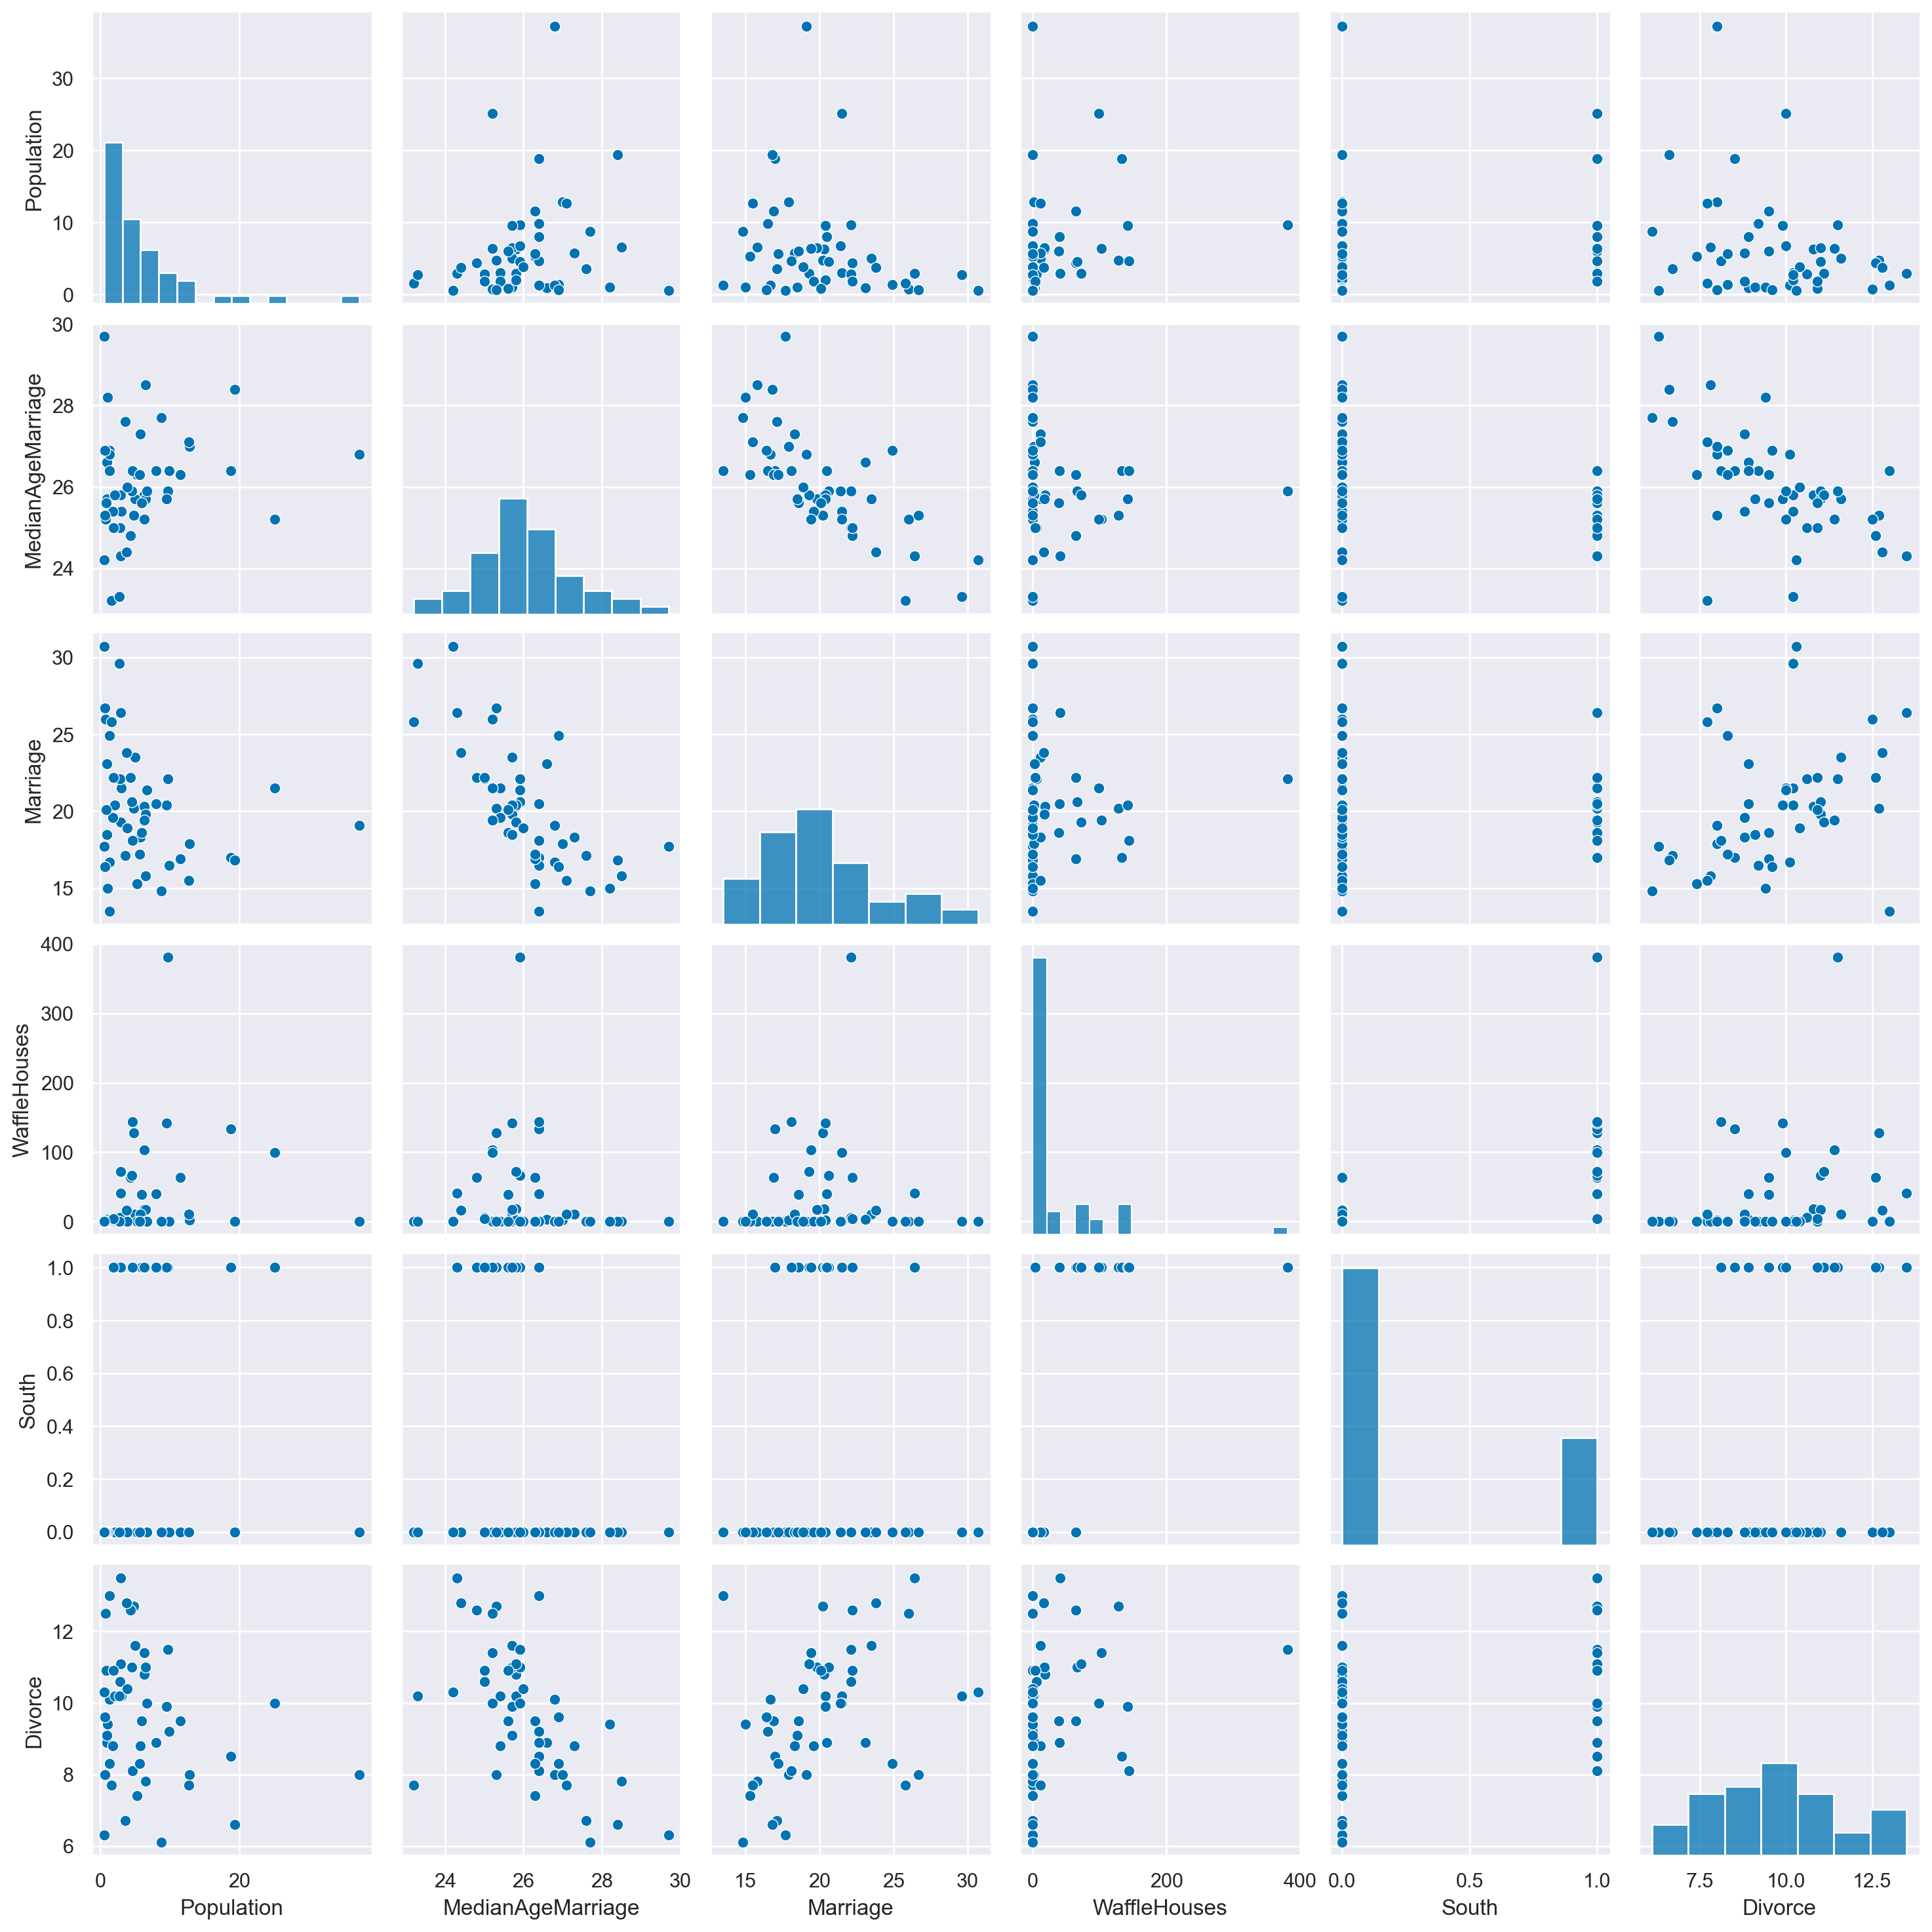

In [4]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(divorce, x_vars=vars, y_vars=vars);

Per semplicità, ci concentreremo sul tasso di matrimonio e sull'età media del matrimonio come predittori per il tasso di divorzio.

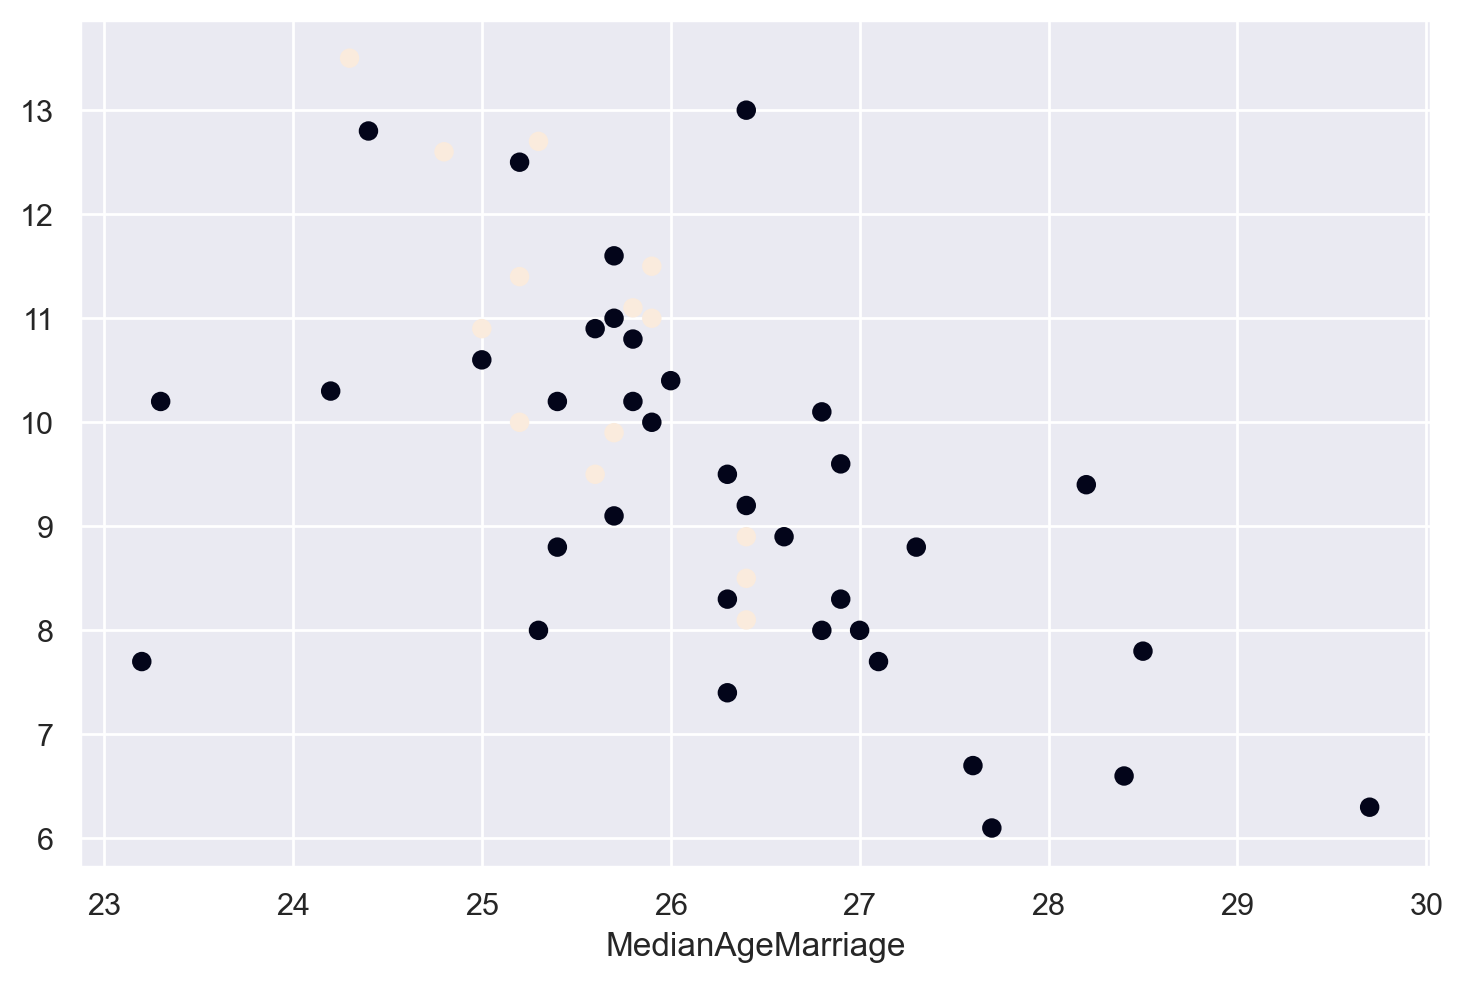

In [5]:
plt.scatter(divorce["MedianAgeMarriage"], divorce["Divorce"], c=divorce["South"])
plt.xlabel("MedianAgeMarriage")
plt.show()

Si noti Maine e Idaho presentano entrambi caratteristiche inusuali quando si tratta di tendenze nel divorzio. Il Maine mostra un tasso di divorzio insolitamente alto rispetto alla tendenza generale, mentre l'Idaho ha un tasso di divorzio insolitamente basso.

Queste anomalie possono essere esaminate in modo rigoroso attraverso l'utilizzo di metodi statistici avanzati. Un modo principale per quantificare questi outlier è attraverso l'utilizzo della statistica PSIS $k$, una tecnica che può aiutare a determinare l'effetto delle osservazioni estreme su una distribuzione.

Un'altra considerazione importante nel contesto di questi Stati è l'ipotesi che la popolazione sia il risultato di una miscela di distribuzioni gaussiane. Questo approccio, noto come "Mixing Gaussians," assume che vi siano sottogruppi all'interno della popolazione che seguono diverse distribuzioni gaussiane.

Quando si mescolano distribuzioni gaussiane con la stessa media ma varianze diverse, si ottengono code più spesse. Questo fenomeno porta alla distribuzione Student-t, che è particolarmente utile nell'analisi di dati con code pesanti.

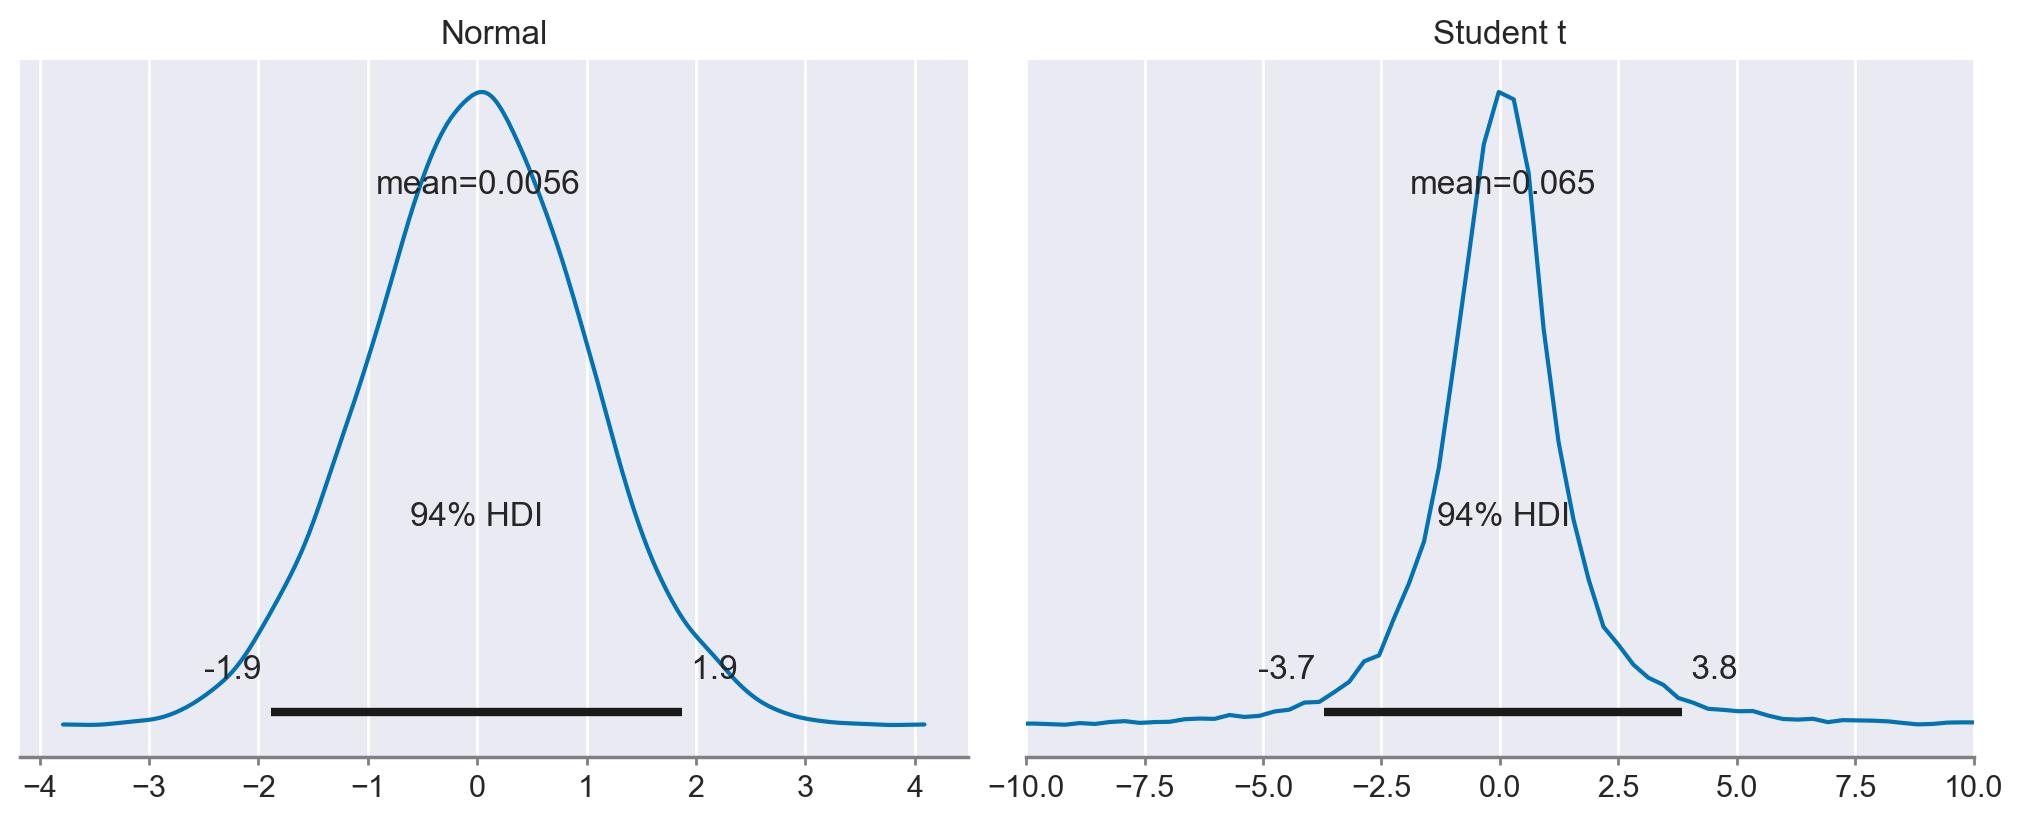

In [7]:
az.plot_posterior(
    {
        "Normal": np.random.normal(size=10000),
        "Student t": np.random.standard_t(df=2, size=10000),
    },
    figsize=(10, 4)
)
plt.xlim(-10, 10);

Nell'ambito della statistica, la distribuzione gaussiana e la distribuzione Student-t sono due strumenti fondamentali utilizzati per modellare i dati. Tuttavia, presentano differenze significative nella loro reazione agli outlier.

La distribuzione gaussiana è spesso descritta come molto scettica riguardo a qualsiasi valore che si trova al di fuori di poche deviazioni standard dalla media. In altre parole, gli outlier sono considerati altamente improbabili in una distribuzione normale e possono avere un impatto notevole sull'analisi, spesso portando a conclusioni errate se non trattati correttamente.

D'altra parte, la distribuzione Student-t è molto meno disturbata dagli outlier e mostra un minor scetticismo nei loro confronti. Questo è dovuto alla forma delle sue code, che sono più pesanti rispetto a quelle della distribuzione gaussiana. Di conseguenza, la distribuzione Student-t assegna una probabilità maggiore agli outlier, rendendola più robusta in presenza di valori anomali.

Questa differenza nelle reazioni agli outlier può avere implicazioni importanti nella scelta del modello più appropriato per un dato set di dati. Se i dati contengono molti outlier, o se c'è una ragione per credere che gli outlier possano essere un fenomeno intrinseco e non un errore, allora la distribuzione Student-t potrebbe essere una scelta più appropriata. D'altro canto, se gli outlier sono rari e considerati non informativi, allora un approccio gaussiano potrebbe essere più adatto.

In sintesi, mentre la distribuzione gaussiana può essere sensibile agli outlier, considerandoli come eventi rari e quindi potenzialmente problematici, la distribuzione Student-t è meno perturbata da questi valori estremi. La scelta tra queste due distribuzioni dovrebbe quindi essere guidata dalla natura dei dati e dall'importanza attribuita agli outlier nell'analisi.

Prima di tutto, notiamo che le nostre variabili predittive hanno scale leggermente diverse. È una buona pratica standardizzare le nostre variabili predittive e di risposta in modo che abbiano una media di 0 e una deviazione standard di 1.

In [8]:
A = scale(divorce["MedianAgeMarriage"])
D = scale(divorce["Divorce"]) # tasso di divorzio
M = scale(divorce["Marriage"]) # tasso di matrimonio

Implementiamo un modello di regressione lineare per analizzare la relazione tra il tasso di divorzio (variabile dipendente) e le variabili indipendenti, che sono l'età media al matrimonio e il tasso di matrimonio. In questa analisi iniziale, l'ipotesi sottostante è che gli errori, o residui, seguano una distribuzione normale (gaussiana). 

In [9]:
with pm.Model() as n_model:
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    mu = a + bM * M + bA * A
    Dmod = pm.Normal("D", mu, sigma, observed=D)
    
    n_sample = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:06.442634
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1324.23it/s]
Sampling time = 0:00:01.764824
Transforming variables...
Transformation time = 0:00:00.080383
Computing Log Likelihood...
Log Likelihood time = 0:00:00.134458


Si noti che l'argomento `idata_kwargs={"log_likelihood": True}` passato alla funzione `sample_numpyro_nuts` è usato per specificare le opzioni per la creazione dell'oggetto `InferenceData` che sarà restituito. In questo caso, stiamo indicando che vogliamo che il logaritmo della verosimiglianza sia incluso nell'oggetto `InferenceData`. Il logaritmo della verosimiglianza può essere utilizzato per ulteriori analisi e diagnostica, come il calcolo del LOO (Leave-One-Out Cross-Validation).

In un secondo modello assumiamo che gli errori seguano una distribuzione $t$ di Student con 2 gradi di libertà.

In [10]:
with pm.Model() as t_model:
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    mu = a + bM * M + bA * A
    Dmod = pm.StudentT("D", mu=mu, sigma=sigma, nu=2, observed=D)

    t_sample = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:06.691075
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1286.39it/s]
Sampling time = 0:00:01.665458
Transforming variables...
Transformation time = 0:00:00.056463
Computing Log Likelihood...
Log Likelihood time = 0:00:00.172927


Il modello che assume una distribuzione gaussiana dei residui produce una stima a posteriori della pendenza della retta di regressione che è maggiore rispetto a quella ottenuta mediante un modello che assume una distribuzione $t$ di Student per gli errori.

```{note}
:class: dropdown
Si tenga presente che, in questo contesto, abbiamo adottato un modello che presuppone una distribuzione $ t $ di Student con $\nu = 2$ gradi di libertà. Questa specifica scelta di $\nu$ corrisponde a una distribuzione $ t $ di Student caratterizzata da code particolarmente pesanti. Generalmente, il parametro $\nu$ può essere stimato direttamente dal modello stesso. Per un esempio pratico di questo approccio, si faccia riferimento al [case study](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html) disponibile sul sito di [PyMC](https://www.pymc.io/welcome.html).
```

In [11]:
az.summary(n_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.604,0.159,-0.904,-0.307,0.003,0.002,2864.0,2868.0,1.0
bM,-0.059,0.154,-0.335,0.249,0.003,0.002,2963.0,2922.0,1.0
a,0.001,0.116,-0.212,0.222,0.002,0.002,3734.0,2704.0,1.0
sigma,0.837,0.089,0.676,1.005,0.002,0.001,3420.0,2450.0,1.0


In [12]:
az.summary(t_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.698,0.148,-0.973,-0.411,0.002,0.002,3585.0,2875.0,1.0
bM,0.047,0.199,-0.310,0.425,0.004,0.003,3214.0,3046.0,1.0
a,0.033,0.113,-0.178,0.244,0.002,0.002,3938.0,3206.0,1.0
sigma,0.584,0.086,0.429,0.749,0.001,0.001,3785.0,3261.0,1.0


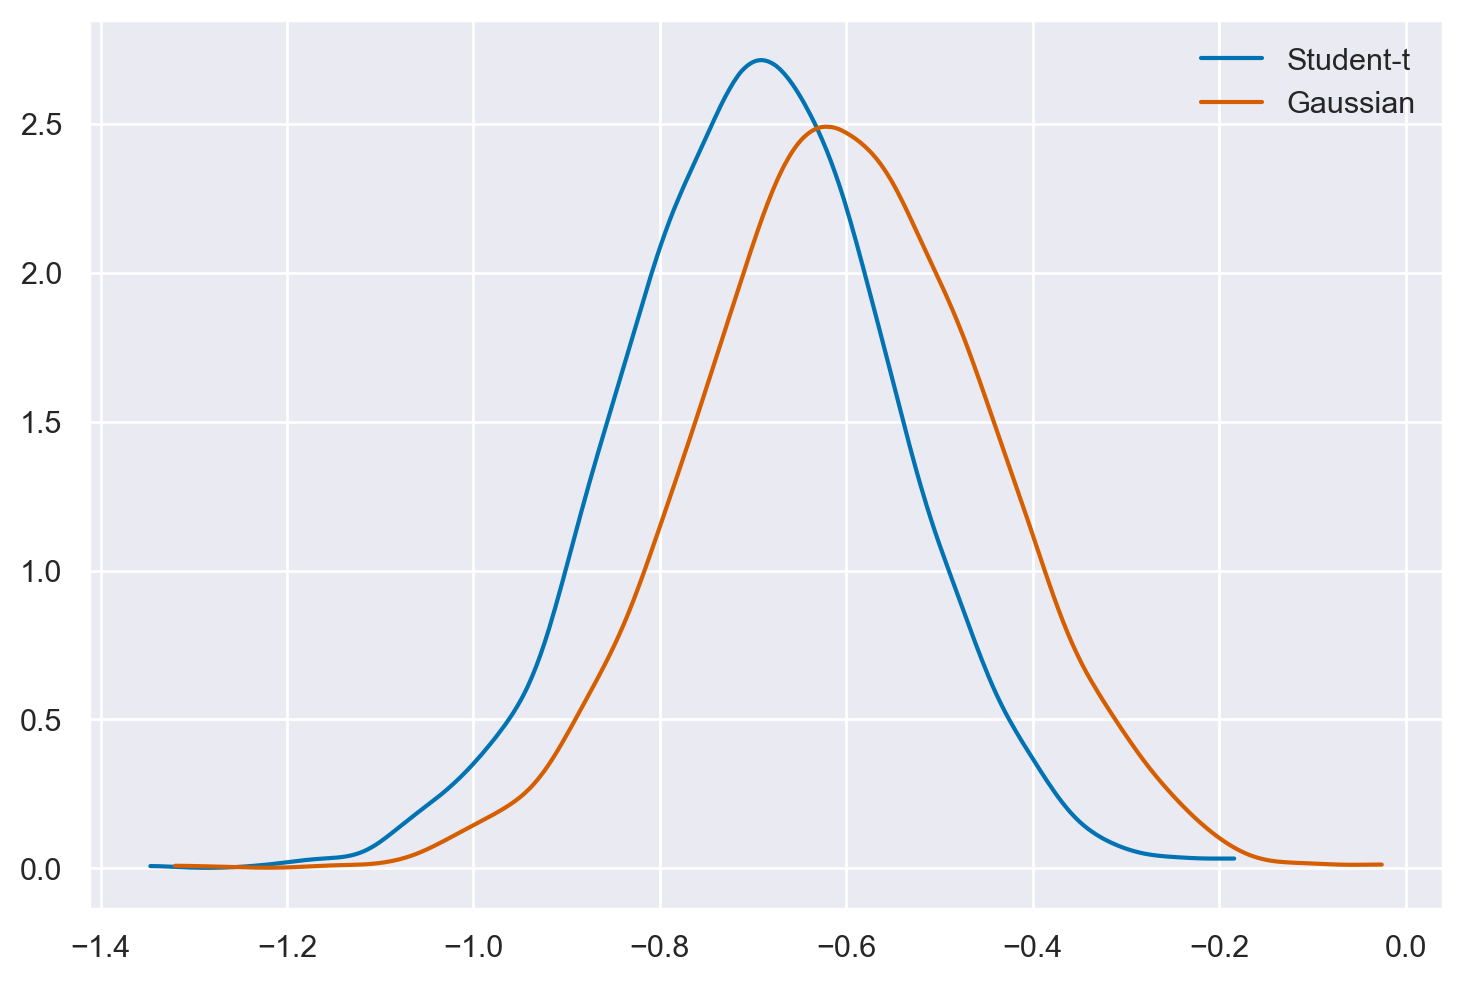

In [13]:
az.plot_dist(t_sample.posterior["bA"], color="C0", label="Student-t")
az.plot_dist(n_sample.posterior["bA"], color="C3", label="Gaussian");

In [14]:
az.loo(n_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -64.61     6.43
p_loo        5.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
az.loo(t_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -67.01     5.70
p_loo        6.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Si osservi che, quando si sono presentati dati anomali, l'impiego della distribuzione $t$ di Student ha portato a un adattamento del modello più accurato, come evidenziato dai valori diagnostici Pareto $k$.

## Commenti e considerazioni conclusive

Nel contesto della statistica, l'eterogeneità non osservata nei dati può spesso essere modellata come una miscela di distribuzioni gaussiane. Questo approccio porta a code più spesse nella distribuzione, il che significa che il modello è meno "sorpreso" da valori estremi. Tuttavia, è solitamente impossibile stimare con precisione la distribuzione di questi valori estremi. Spesso, la scelta deve essere fatta tramite simulazioni esplorando tutti i gradi di libertà per la distribuzione Student-t. Nei processi con code spesse, i campioni estremi sono ancora rari ma possono avere un grande effetto sulla modellazione. La regressione Student-t è un buon punto di partenza predefinito per i domini "poco teorizzati", poiché l'approccio gaussiano può essere troppo "scettico" e non adeguato per gestire questi effetti.

Una delle sfide chiave in statistica è prevedere la prossima osservazione dallo stesso processo. Questo compito, noto come previsione, può essere complesso. Per misurare e gestire l'accuratezza nelle previsioni, esistono strumenti potenti come PSIS (Pareto Smoothed Importance Sampling) e tecniche di regolarizzazione. In questo capitolo abbiamo usato i valori diagnostici Pareto $k$ per valutare la bontà di adattamento del modello ai dati. PSIS e i valori diagnostici Pareto $k$ sono strettamente collegati, con PSIS che utilizza la stima di $k$ per migliorare l'adattamento del modello, e i valori di $k$ che servono come strumento diagnostico per valutare la qualità dell'importance sampling e dell'adattamento del modello stesso. Questi metodi possono aiutare a creare modelli più robusti e accurati, soprattutto quando si tratta di dati con caratteristiche complesse come valori anomali e eterogeneità non osservata. 

In sintesi, la regressione robusta attraverso l'utilizzo di distribuzioni come la Student-t può offrire una metodologia efficace per affrontare dati complessi e eterogenei. La capacità di gestire valori estremi e l'uso di strumenti avanzati per la previsione rappresentano un passo importante nella creazione di modelli statistici più robusti e affidabili.

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Jan 25 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

pytensor: 2.18.4

seaborn   : 0.13.0
matplotlib: 3.8.2
arviz     : 0.17.0
pymc      : 5.10.3
pandas    : 2.1.4
numpy     : 1.26.2

Watermark: 2.4.3

